In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from peak_picking import *

# CEOAE data loading
mat_CEOAE = scipy.io.loadmat("data/ceoae2/ceoae50g130R29rs20.mat")

fs = mat_CEOAE['fs'].flatten()  # sample rate
CEOAE = mat_CEOAE['click50'].flatten()  # CEOAE wave
time_axis = np.arange(0, np.size(CEOAE)/fs, 1/fs)

# we cut off spectrum because our reference is only at isolated frequencies
spectrum = np.fft.fft(CEOAE)
fx = np.arange(len(spectrum))*fs/len(spectrum)
spectrum = spectrum[(fx >= 1000) & (fx <= 3200)]
fx = fx[(fx >= 1000) & (fx <= 3200)]

# unwrapped phase of the SFOAE wave
phase_unwrap_CEOAE = np.unwrap(np.angle(spectrum))

freq_range_CEOAE = np.size(fx)  # maximum index on the frequency axis

# peak picking
maximas_CEOAE = findLocalMaxima(np.real(20*np.log10(spectrum)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CEOAE = peakNeighbours(maximas_CEOAE, shift, np.size(fx))


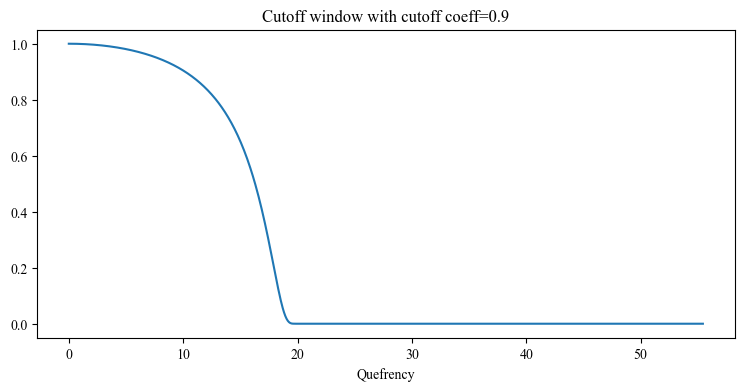

In [74]:
from cutoff_window import *
from scipy.interpolate import CubicSpline
from cepstrum_smoothing import *
from peak_picking import *
from gradient_delay import *

# an estimate of the secular variation of the unwrapped phase from which much of the phase rippling pattern has been ironed out
phi = smoothedPhi(phase_unwrap_CEOAE)
# cutoff to have only an increasing tendency
phi_end = findLocalMaxima(phi)[0] + 1

# plotting the smoothed phi
'''
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(fx, phi, "b--", label="Smoothed phi")
ax.plot(fx[phi_end], phi[phi_end], "rx", label="Local maxima")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Unwrapped phase (cycles)")
plt.title("Smoothed phi variable")
plt.legend()
plt.show()
'''

# resampling phi
phi_N_samples = 1000
phi_resample = np.linspace(0, np.floor(phi[phi_end-1]), phi_N_samples)

# calculation of the number of cycles travelled by phi
# phi is already in cycles (no need to divide by 2pi)
N_cycles = np.round(np.max(phi) - np.min(phi))
# N_cycles = 16

# calculate logarithm of SFOAE
log_CEOAE = np.log(spectrum)  # = np.log(np.abs(SFOAE)) + 1j*phase_unwrap_SFOAE

# cubic spline interpolation SEPARATELY for the real and imaginary part (resample w.r.t. to phi)
real_log_CEOAE_interp = CubicSpline(
    phi[:phi_end], np.real(log_CEOAE[:phi_end]))
# unwrapping to avoid phase jumps
imag_log_CEOAE_interp = CubicSpline(
    phi[:phi_end], np.unwrap(np.imag(log_CEOAE[:phi_end])))

'''
# linear interpolation
real_log_CEOAE_interp = np.interp(phi_resample,phi[:phi_end], np.real(log_SFOAE[:phi_end]))
imag_log_COEAE_interp = np.interp(phi_resample,phi[:phi_end], np.unwrap(np.imag(log_SFOAE[:phi_end])))
'''

# evaluating the interpolated data on the resampled phi
real_log_CEOAE_values = real_log_CEOAE_interp(phi_resample)
imag_log_CEOAE_values = imag_log_CEOAE_interp(
    phi_resample)  # + 2*np.pi*phi_resample

# plotting the real and imaginary values
'''
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(real_log_CEOAE_values, label="Real part")
ax.plot(imag_log_CEOAE_values, label="Imaginary part")
plt.legend()
plt.show()
'''

# wrapping up back the phi into <-pi; +pi>
# 2*np.pi*phi_resample  ~ full phase cycle is 2*pi radians
# + np.pi               ~ shifting the range to be centered at zero for <-pi; +pi>
# % (2 * np.pi)         ~ to obtain a resulte between <0; +2*pi>
# - np.pi               ~ to shift into <-pi; +pi> interval
wrapped_phi = (2*np.pi*phi_resample + np.pi) % (2 * np.pi) - np.pi

# Eq. 18, calculation of F(X(phi) + j*2*pi*phi) -> perform FFT with respect to phi
# "Computing the transforms of its real and imaginary parts separately often proves convenient"
fft_log_CEOAE_phi = np.fft.fft(
    real_log_CEOAE_values) + 1j*np.fft.fft(imag_log_CEOAE_values + 2*np.pi*phi_resample)
# fft_log_SFOAE_phi = np.fft.fft(real_log_SFOAE_values*np.exp(1j*imag_log_SFOAE)) + 1j*np.fft.fft(imag_log_SFOAE_values)

fft_log_CEOAE_only_real = np.fft.fft(real_log_CEOAE_values)

# obtain the quefrency axis
sample_rate = 1/(phi_resample[1]-phi_resample[0])
quefrency = np.arange(len(phi_resample))*sample_rate/(len(phi_resample))

# cutoff window
cutoff_coeff = 0.9
eta_c = cutoff_coeff*N_cycles  # quefrency cutoff

smooth_order = 10  # order of the smoothing function
window = getWindow(quefrency, eta_c, smooth_order)  # cutoff window

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(quefrency, window)
plt.title(f"Cutoff window with cutoff coeff={cutoff_coeff}")
plt.xlabel("Quefrency")
plt.show()

# plotting the comparison of cuttoff window and F{log(X)}
'''
fig, ax = plt.subplots(figsize=(9,4))
ax.semilogx(quefrency/eta_c, np.abs(fft_log_CEOAE_only_real)/100, label="abs(F{real_log(X)})")
ax.semilogx(quefrency/eta_c, np.abs(fft_log_CEOAE_phi)/100, label="abs(F{log(X)})")
ax.semilogx(quefrency/eta_c, window, label="Cutoff window")
ax.set_xlim((0.1, 3))
ax.set_ylim((0, 1.1))
plt.xlabel("Quefrency/cutoff")
plt.title("Cutoff window detail")
plt.legend()
plt.show()
'''

# obtaining the smoothed signal -> apply the window function to the FFT output in order to cutoff at eta_c quefrency
log_0_CEOAE = np.fft.ifft(window*fft_log_CEOAE_phi) - 1j*wrapped_phi
# log_0_SFOAE = np.fft.ifft(window*fft_log_SFOAE_phi) - 2*np.pi*1j*phi_resample

# from LOG(SFOAE) to SFOAE
smooth_CEOAE = np.exp(np.real(log_0_CEOAE)) * \
    np.exp(1j*np.unwrap(np.imag(log_0_CEOAE)))
smooth_phase = np.unwrap(np.angle(smooth_CEOAE))

# cubic spline interpolation back to Freq axis
# resample w.r.t. to phi
abs_smooth_CEOAE_interp = CubicSpline(phi_resample, np.abs(smooth_CEOAE))
phase_CEOAE_interp = CubicSpline(
    phi_resample, np.unwrap(np.angle(smooth_CEOAE)))

# working with SFOAE (not log(SFOAE))
abs_smooth_CEOAE_values = abs_smooth_CEOAE_interp(phi[:phi_end])
unwrap_smooth = phase_CEOAE_interp(phi[:phi_end])
unwrap_original = phase_unwrap_CEOAE

# plotting the unwrapped phases of both signals
'''
# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9, 4))
 # ax.plot(freq_SFOAE, np.log10(np.exp(log_SFOAE)), "g", label="Original LOG10")
# ax1.plot(freq_SFOAE, 20*np.log10(np.abs(SFOAE)))
# ax1.plot(freq_SFOAE[:phi_end], 20*np.log10(abs_smooth_SFOAE_values))
# ax1.set_ylim((-125,-90))
fig, ax2 = plt.subplots(figsize=(9, 4))
ax2.plot(freq_SFOAE, unwrap_original, "b--", label="Original unwrapped phase")
ax2.plot(freq_SFOAE[:phi_end], unwrap_smooth, "r", label="Smoothed unwrapped phase")
ax2.set_ylim((-120, 50))
plt.title("Comparison of unwrapped phases")
plt.xlabel("Freqeuncy (Hz)")
plt.ylabel("Phase (rad)")
plt.legend()
plt.show()
'''
# computing the final gradient-delays of both signals
original_grad_delay = -np.gradient(unwrap_original, fx)/(2*np.pi)
smoothed_grad_delay = - \
    np.gradient(unwrap_smooth, fx[:phi_end])/(2*np.pi)


ISOINTENSITY (REFERENCE)

In [75]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 3200, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_20dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)


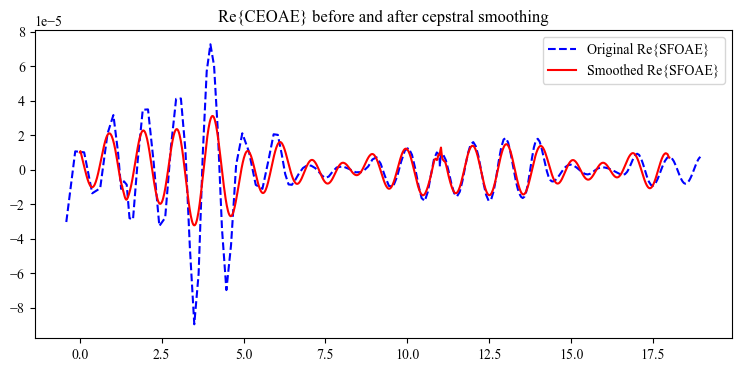

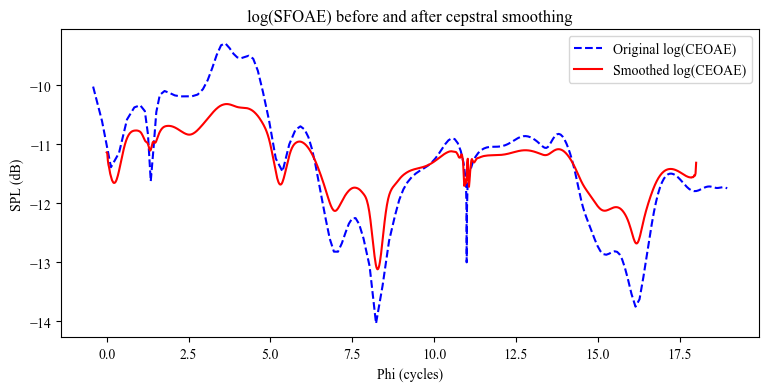

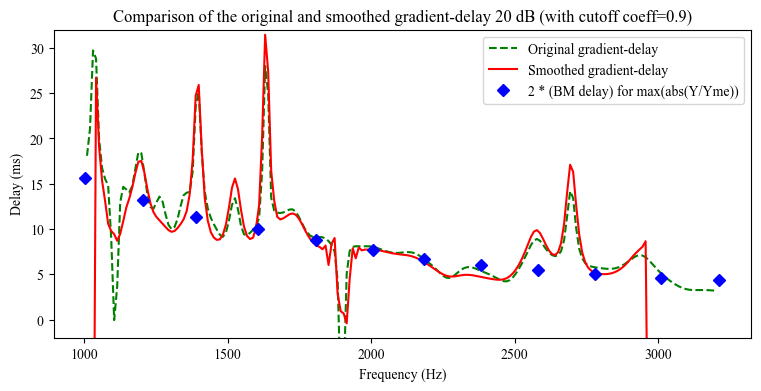

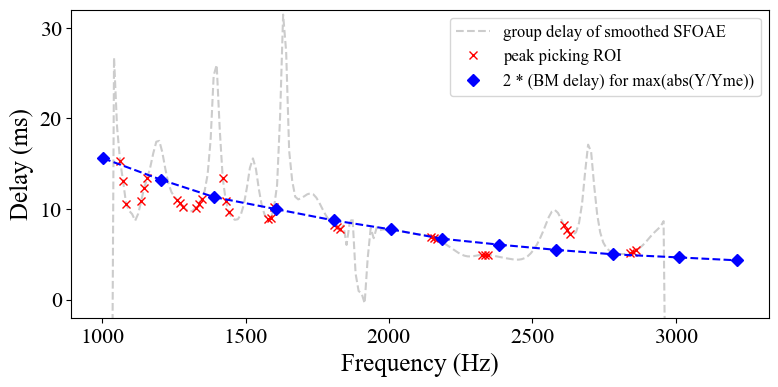

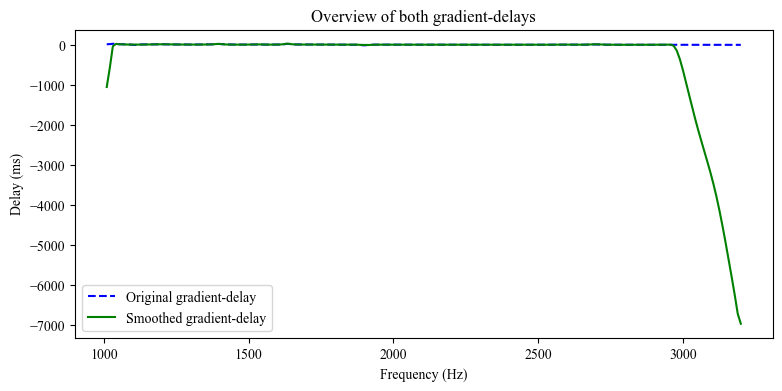

In [76]:
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(phi, np.real(spectrum), "b--", label="Original Re{SFOAE}")
ax.plot(phi_resample, np.real(smooth_CEOAE), "r", label="Smoothed Re{SFOAE}")
plt.legend()
plt.title("Re{CEOAE} before and after cepstral smoothing")
plt.show()
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(phi, np.real(log_CEOAE), "b--", label="Original log(CEOAE)")
ax.plot(phi_resample, np.real(log_0_CEOAE), "r", label="Smoothed log(CEOAE)")
plt.legend()
plt.xlabel("Phi (cycles)")
plt.ylabel("SPL (dB)")
# plt.xlim(0, 16)
# plt.ylim(-15.5, -10.7)
plt.title("log(SFOAE) before and after cepstral smoothing")
plt.show()
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(fx, 1000*original_grad_delay,
        "g--", label="Original gradient-delay")
ax.plot(fx[:phi_end], 1000*smoothed_grad_delay,
        "r", label="Smoothed gradient-delay")

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx], 1000*grad_delay_ISOINT[max_idx], "bD",
            label='2 * (BM delay) for max(abs(Y/Yme))' if i == 0 else None)

plt.title(
    f"Comparison of the original and smoothed gradient-delay 20 dB (with cutoff coeff={cutoff_coeff})")
plt.ylim(-2, 32)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Delay (ms)")
plt.show()
# ------------------------------------------------------------------------------
# MAIN RESULT
peaks_adjust = adjustPeaks(ext_maximas_CEOAE, fx[:phi_end])

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(fx[:phi_end], 1000*smoothed_grad_delay,
        '0.8', linestyle='--', label='group delay of smoothed CEOAE')

ax.plot(fx[peaks_adjust], 1000*smoothed_grad_delay[peaks_adjust],
        "rx", label='peak picking ROI')

# ax.plot(freq_CR[ext_maximas_CR], 1000*group_delay_CR[ext_maximas_CR],
#         "g^", label='peak picking original CR')

# ax.plot(freq_NL[ext_maximas_NL], 1000*group_delay_NL[ext_maximas_NL],
#         "kv", label='peak picking original NL')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx], 1000*grad_delay_ISOINT[max_idx], "bD",
            label='2 * (BM delay) for max(abs(Y/Yme))' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]], freq_ISOINT[max_idx]],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")


# plt.title(f"Smoothed gradient-delay (with cutoff coeff={cutoff_coeff})")
plt.ylim(-2, 32)
plt.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Frequency (Hz)', fontdict={"fontsize": 18})
ax.set_ylabel('Delay (ms)', fontdict={"fontsize": 18})
plt.show()
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(fx, 1000*original_grad_delay,
        "b--", label="Original gradient-delay")
ax.plot(fx[:phi_end], 1000*smoothed_grad_delay,
        "g", label="Smoothed gradient-delay")
plt.title("Overview of both gradient-delays")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Delay (ms)")
plt.show()
